In [1]:
"""
EVmutation Couplings Model
==========================

This notebook demonstrates the CouplingsModel class for computing evolutionary 
couplings and statistical energies from protein sequence alignments.

Class to store parameters of undirected graphical model of sequences and perform 
calculations using the model (statistical energies, coupling scores).

Authors:
  Thomas A. Hopf (thomas_hopf@hms.harvard.edu)
"""

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

In [2]:
from collections.abc import Iterable
from copy import deepcopy

In [3]:
from numba import jit
import numpy as np
import pandas as pd

Constants

In [4]:
_SLICE = np.s_[:]
HAMILTONIAN_COMPONENTS = [FULL, COUPLINGS, FIELDS] = [0, 1, 2]
NUM_COMPONENTS = len(HAMILTONIAN_COMPONENTS)

Methods for fast calculations (moved outside of class for numba jit)

In [5]:
@jit(nopython=True)
def _hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, NUM_COMPONENTS))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            hi_sum += h_i[i, A[i]]
            for j in range(i + 1, L):
                Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

In [6]:
@jit(nopython=True)
def _single_mutant_hamiltonians(target_seq, J_ij, h_i):
    """
    Calculate matrix of all possible single-site substitutions

    Parameters
    ----------
    L : int
        Length of model
    num_symbols : int
        Number of states of model
    target_seq : np.array(int)
        Target sequence for which mutant energy differences will be calculated
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size L x num_symbols x 3, where the first two dimensions correspond to
        Hamiltonian differences compared to target sequence for all possible substitutions in
        all positions, and the third dimension corresponds to the deltas of
        1) total Hamiltonian and the 2) J_ij and 3) h_i sub-sums
    """
    L, num_symbols = h_i.shape
    H = np.empty((L, num_symbols, NUM_COMPONENTS))

    # iterate over all positions
    for i in range(L):
        # iterate over all substitutions
        for A_i in range(num_symbols):
            # iterate over couplings to all other sites
            delta_hi = h_i[i, A_i] - h_i[i, target_seq[i]]
            delta_Jij = 0.0

            for j in range(L):
                if i != j:
                    delta_Jij += (
                        J_ij[i, j, A_i, target_seq[j]] -
                        J_ij[i, j, target_seq[i], target_seq[j]]
                    )

            H[i, A_i] = [delta_Jij + delta_hi, delta_Jij, delta_hi]

    return H

In [7]:
@jit(nopython=True)
def _delta_hamiltonian(pos, subs, target_seq, J_ij, h_i):
    """
    Parameters
    ----------
    pos : np.array(int)
        Vector of substituted positions
    subs : np.array(int)
        Vector of symbols above positions are substituted to
    target_seq : np.array(int)
        Target sequence for which mutant energy differences will be calculated
        relative to
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Vector of length 3, where elements correspond to delta of
        1) total Hamiltonian and the 2) J_ij and 3) h_i sub-sums
    """
    L, num_symbols = h_i.shape

    M = pos.shape[0]
    delta_hi = 0.0
    delta_Jij = 0.0

    # iterate over all changed positions
    for m in range(M):
        i = pos[m]
        A_i = subs[m]

        # change in fields
        delta_hi += h_i[i, A_i] - h_i[i, target_seq[i]]

        # couplings to all other positions in sequence
        for j in range(L):
            if i != j:
                delta_Jij += (
                    J_ij[i, j, A_i, target_seq[j]] -
                    J_ij[i, j, target_seq[i], target_seq[j]]
                )

        # correct couplings between substituted positions:
        # 1) do not count coupling twice (remove forward
        #     and backward coupling)
        # 2) adjust background to new sequence
        for n in range(m + 1, M):
            j = pos[n]
            A_j = subs[n]
            # remove forward and backward coupling delta
            delta_Jij -= J_ij[i, j, A_i, target_seq[j]]
            delta_Jij -= J_ij[i, j, target_seq[i], A_j]
            delta_Jij += J_ij[i, j, target_seq[i], target_seq[j]]
            # the following line cancels out with line further down:
            # delta_Jij += J_ij[i, j, target_seq[i], target_seq[j]]

            # now add coupling delta once in correct background
            delta_Jij += J_ij[i, j, A_i, A_j]
            # following line cancels out with line above:
            # delta_Jij -= J_ij[i, j, target_seq[i], target_seq[j]]

    return np.array([delta_Jij + delta_hi, delta_Jij, delta_hi])

In [8]:
class CouplingsModel:
    """
    Class to store parameters of pairwise undirected graphical model of sequences
    and compute evolutionary couplings, sequence statistical energies, etc.
    """

    def __init__(self, filename, precision="float32", file_format="plmc_v2", **kwargs):
        """
        Initializes the object with raw values read from binary .Jij file

        Parameters
        ----------
        filename : str
            Binary Jij file containing model parameters from plmc software
        alphabet : str
            Symbols corresponding to model states (e.g. "-ACGT").
        precision : {"float32", "float64"}, default: "float32"
            Sets if input file has single (float32) or double precision (float64)
        }
        file_format : {"plmc_v2", "plmc_v1"}, default: "plmc_v2"
            File format of parameter file.

            Note: The use of "plmc_v1" is discouraged and only for backwards
            compatibility as this format lacks crucial information about
            parameters used by this class. Users are responsible for supplying
            the missing values (e.g. regularization strength, alphabet or M_eff)
            manually via the respective member variables/properties.
        """
        if file_format == "plmc_v2":
            self.__read_plmc_v2(filename, precision)
        elif file_format == "plmc_v1":
            self.__read_plmc_v1(
                filename, precision, kwargs.get("alphabet", None)
            )
        else:
            raise ValueError(
                "Illegal file format {}, valid options are:"
                "plmc_v2, plmc_v1".format(
                    file_format
                )
            )

        self.alphabet_map = {s: i for i, s in enumerate(self.alphabet)}

        # in non-gap mode, focus sequence is still coded with a gap character,
        # but gap is not part of model alphabet anymore; so if mapping crashes
        # that means there is a non-alphabet character in sequence array
        # and therefore there is no focus sequence.
        try:
            self.target_seq_mapped = np.array([self.alphabet_map[x] for x in self.target_seq])
            self.has_target_seq = (np.sum(self.target_seq_mapped) > 0)
        except KeyError:
            self.target_seq_mapped = np.zeros((self.L), dtype=np.int32)
            self.has_target_seq = False

        self._reset_precomputed()

    def _reset_precomputed(self):
        """
        Delete precomputed values (e.g. mutation matrices)
        """
        self._single_mut_mat_full = None
        self._double_mut_mat = None
        self._cn_scores = None
        self._fn_scores = None
        self._mi_scores_raw = None
        self._mi_scores_apc = None
        self._ecs = None

    def __read_plmc_v2(self, filename, precision):
        """
        Read updated Jij file format from plmc.

        Parameters
        ----------
        filename : str
            Binary Jij file containing model parameters
        precision : {"float32", "float64"}
            Sets if input file has single or double precision

        """
        with open(filename, "rb") as f:
            # model length, number of symbols, valid/invalid sequences
            # and iterations
            self.L, self.num_symbols, self.N_valid, self.N_invalid, self.num_iter = (
                np.fromfile(f, "int32", 5)
            )

            # theta, regularization weights, and effective number of samples
            self.theta, self.lambda_h, self.lambda_J, self.lambda_group, self.N_eff = (
                np.fromfile(f, precision, 5)
            )

            # Read alphabet (make sure we get proper unicode rather than byte string)
            self.alphabet = np.fromfile(
                f, "S1", self.num_symbols
            ).astype("U1")

            # weights of individual sequences (after clustering)
            self.weights = np.fromfile(
                f, precision, self.N_valid + self.N_invalid
            )

            # target sequence and index mapping, again ensure unicode
            self._target_seq = np.fromfile(f, "S1", self.L).astype("U1")
            self.index_list = np.fromfile(f, "int32", self.L)

            # single site frequencies f_i and fields h_i
            self.f_i, = np.fromfile(
                f, dtype=(precision, (self.L, self.num_symbols)), count=1
            )

            self.h_i, = np.fromfile(
                f, dtype=(precision, (self.L, self.num_symbols)), count=1
            )

            # pair frequencies f_ij and pair couplings J_ij / J_ij
            self.f_ij = np.zeros(
                (self.L, self.L, self.num_symbols, self.num_symbols)
            )

            self.J_ij = np.zeros(
                (self.L, self.L, self.num_symbols, self.num_symbols)
            )

            for i in range(self.L - 1):
                for j in range(i + 1, self.L):
                    self.f_ij[i, j], = np.fromfile(
                        f, dtype=(precision, (self.num_symbols, self.num_symbols)),
                        count=1
                    )
                    self.f_ij[j, i] = self.f_ij[i, j].T

            for i in range(self.L - 1):
                for j in range(i + 1, self.L):
                    self.J_ij[i, j], = np.fromfile(
                        f, dtype=(precision, (self.num_symbols, self.num_symbols)),
                        count=1
                    )
                    self.J_ij[j, i] = self.J_ij[i, j].T

    def __read_plmc_v1(self, filename, precision, alphabet=None):
        """
        Read original eij/Jij file format from plmc. Use of this old format
        is discouraged (see constructor documentation for details)

        Parameters
        ----------
        filename : str
            Binary Jij file containing model parameters
        precision : {"float32", "float64"}
            Sets if input file has single or double precision
        alphabet : str, default: None

        """
        # local definitions of alphabets for backwards compatibility
        # better: use v2 file format which includes this information
        GAP = "-"
        ALPHABET_PROTEIN_NOGAP = "ACDEFGHIKLMNPQRSTVWY"
        ALPHABET_PROTEIN = GAP + ALPHABET_PROTEIN_NOGAP

        with open(filename, "rb") as f:
            # model length, number of symbols
            self.L, = np.fromfile(f, "int32", 1)
            self.num_symbols, = np.fromfile(f, "int32", 1)

            # Old format does not have alphabet in file, so need
            # to guess it or use user-supplied alphabet.
            # if no alphabet is given, try to guess
            if alphabet is None:
                if self.num_symbols == 21:
                    alphabet = ALPHABET_PROTEIN
                elif self.num_symbols == 20:
                    alphabet = ALPHABET_PROTEIN_NOGAP
                else:
                    raise ValueError(
                        "Could not guess default alphabet for "
                        "{} states, specify alphabet parameter.".format(
                            self.num_symbols
                        )
                    )
            else:
                # verify if size of given alphabet matches model
                if len(alphabet) != self.num_symbols:
                    raise ValueError(
                        "Size of alphabet ({}) does not agree with "
                        "number of states in model ({})".format(
                            len(alphabet), self.num_symbols
                        )
                    )

            self.alphabet = np.array(list(alphabet))

            # target sequence and index mapping, again ensure unicode
            self._target_seq = np.fromfile(f, "S1", self.L).astype("U1")
            self.index_list = np.fromfile(f, "int32", self.L)

            # set all the information missing in v1 files to None

            # valid/invalid sequences, number of iterations
            self.N_valid = None
            self.N_invalid = None
            self.num_iter = None

            # theta, regularization weights, and effective number of samples
            self.theta = None
            self.lambda_h = None
            self.lambda_J = None
            self.lambda_group = None
            self.N_eff = None

            # weights of individual sequences (after clustering)
            self.weights = None

            # single site frequencies f_i and fields h_i
            self.f_i, = np.fromfile(
                f, dtype=(precision, (self.L, self.num_symbols)), count=1
            )

            self.h_i, = np.fromfile(
                f, dtype=(precision, (self.L, self.num_symbols)), count=1
            )

            # pair frequencies f_ij and pair couplings J_ij / J_ij
            self.f_ij = np.zeros(
                (self.L, self.L, self.num_symbols, self.num_symbols)
            )

            self.J_ij = np.zeros(
                (self.L, self.L, self.num_symbols, self.num_symbols)
            )

            for i in range(self.L - 1):
                for j in range(i + 1, self.L):
                    file_i, file_j = np.fromfile(f, "int32", 2)

                    if i + 1 != file_i or j + 1 != file_j:
                        raise ValueError(
                            "Error: column pair indices inconsistent. "
                            "Expected: {} {}; File: {} {}".format(i + 1, j + 1, file_i, file_j)
                        )

                    self.f_ij[i, j], = np.fromfile(
                        f, dtype=(precision, (self.num_symbols, self.num_symbols)),
                        count=1
                    )
                    self.f_ij[j, i] = self.f_ij[i, j].T

                    self.J_ij[i, j], = np.fromfile(
                        f, dtype=(precision, (self.num_symbols, self.num_symbols)),
                        count=1
                    )
                    self.J_ij[j, i] = self.J_ij[i, j].T

    @property
    def target_seq(self):
        """
        Target/Focus sequence of model used for delta_hamiltonian
        calculations (including single and double mutation matrices)
        """
        return self._target_seq

    @target_seq.setter
    def target_seq(self, sequence):
        """
        Define a new target sequence

        Parameters
        ----------
        sequence : str, or list of chars
            Define a new default sequence for relative Hamiltonian
            calculations (e.g. energy difference relative to wild-type
            sequence).
            Length of sequence must correspond to model length (self.L)
        """
        self._reset_precomputed()

        if len(sequence) != self.L:
            raise ValueError(
                "Sequence length inconsistent with model length: {} {}".format(
                    len(sequence), self.L
                )
            )

        if isinstance(sequence, str):
            sequence = list(sequence)

        self._target_seq = np.array(sequence)
        self.target_seq_mapped = np.array([self.alphabet_map[x] for x in self.target_seq])
        self.has_target_seq = True

    @property
    def index_list(self):
        """
        Target/Focus sequence of model used for delta_hamiltonian
        calculations (including single and double mutation matrices)
        """
        return self._index_list

    @index_list.setter
    def index_list(self, mapping):
        """
        Define a new number mapping for sequences

        Parameters
        ----------
        mapping: list of int
            Sequence indices of the positions in the model.
            Length of list must correspond to model length (self.L)
        """
        if len(mapping) != self.L:
            raise ValueError(
                "Mapping length inconsistent with model length: {} {}".format(
                    len(mapping), self.L
                )
            )

        self._index_list = np.array(mapping)
        self.index_map = {b: a for a, b in enumerate(self.index_list)}

    def convert_sequences(self, sequences):
        """
        Converts sequences in string format into internal symbol representation
        according to alphabet of model

        Parameters
        ----------
        sequences : list of str
            List of sequences (must have same length and correspond to
            model states)

        Returns
        -------
        np.array
            Matrix of size len(sequences) x L of sequences converted to
            integer symbols
        """
        seq_lens = list(set(map(len, sequences)))
        if len(seq_lens) != 1:
            raise ValueError("Input sequences have different lengths: " + str(seq_lens))

        L_seq = seq_lens[0]
        if L_seq != self.L:
            raise ValueError(
                "Sequence lengths do not correspond to model length: {} {}".format(
                    L_seq, self.L
                )
            )

        S = np.empty((len(sequences), L_seq), dtype=np.int)

        try:
            for i, s in enumerate(sequences):
                S[i] = [self.alphabet_map[x] for x in s]
        except KeyError:
            raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))

        return S

    def hamiltonians(self, sequences):
        """
        Calculates the Hamiltonians of the global probability distribution P(A_1, ..., A_L)
        for the given sequences A_1,...,A_L from J_ij and h_i parameters

        Parameters
        ----------
        sequences : list of str
            List of sequences for which Hamiltonian will be computed,
            or converted np.array obtained using convert_sequences method

        Returns
        -------
        np.array
            Float matrix of size len(sequences) x 3, where each row corresponds to the
            1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
        """
        if isinstance(sequences, list):
            sequences = self.convert_sequences(sequences)

        return _hamiltonians(sequences, self.J_ij, self.h_i)

    @property
    def single_mut_mat_full(self):
        """
        Hamiltonian difference for all possible single-site variants

        L x num_symbol x 3 matrix (np.array) containing delta Hamiltonians
        for all possible single mutants of target sequence.
        Third dimension: 1) full Hamiltonian, 2) J_ij, 3) h_i
        """
        if self._single_mut_mat_full is None:
            self._single_mut_mat_full = _single_mutant_hamiltonians(
                self.target_seq_mapped, self.J_ij, self.h_i
            )

        return self._single_mut_mat_full

    @property
    def single_mut_mat(self):
        """
        Hamiltonian difference for all possible single-site variants

        L x num_symbol matrix (np.array) containing delta Hamiltonians
        for all possible single mutants of target sequence.
        """
        return self.single_mut_mat_full[:, :, FULL]

    def delta_hamiltonian(self, substitutions, verify_mutants=True):
        """
        Calculate difference in statistical energy relative to
        self.target_seq by changing sequence according to list of
        substitutions

        Parameters
        ----------
        substitutions : list of tuple(pos, subs_from, subs_to)
            Substitutions to be applied to target sequence
        verify_mutants : bool, optional
            Test if subs_from is consistent with self.target_seq

        Returns
        -------
        np.array
            Vector of length 3 with 1) total delta Hamiltonian,
            2) delta J_ij, 3) delta h_i

        """
        pos = np.empty(len(substitutions), dtype=np.int32)
        subs = np.empty(len(substitutions), dtype=np.int32)

        try:
            for i, (subs_pos, subs_from, subs_to) in enumerate(substitutions):
                pos[i] = self.index_map[subs_pos]
                subs[i] = self.alphabet_map[subs_to]
                if verify_mutants and subs_from != self.target_seq[pos[i]]:
                    raise ValueError(
                        "Inconsistency with target sequence: pos={} target={} subs={}".format(
                            subs_pos, self.target_seq[i], subs_from
                        )
                    )
        except KeyError:
            raise ValueError(
                "Illegal substitution: {}{}{}\nAlphabet: {}\nPositions: {}".format(
                    subs_from, subs_pos, subs_to, self.alphabet_map, self.index_list
                )
            )

        return _delta_hamiltonian(pos, subs, self.target_seq_mapped, self.J_ij, self.h_i)

    @property
    def double_mut_mat(self):
        """
        Hamiltonian difference for all possible double mutant variants

        L x L x num_symbol x num_symbol matrix containing delta Hamiltonians
        for all possible double mutants of target sequence
        """
        if self._double_mut_mat is None:
            self._double_mut_mat = np.zeros(
                (self.L, self.L, self.num_symbols, self.num_symbols)
            )

            seq = self.target_seq_mapped
            for i in range(self.L - 1):
                for j in range(i + 1, self.L):
                    self._double_mut_mat[i, j] = (
                        np.tile(self.single_mut_mat[i], (self.num_symbols, 1)).T +
                        np.tile(self.single_mut_mat[j], (self.num_symbols, 1)) +
                        self.J_ij[i, j] -
                        np.tile(self.J_ij[i, j, :, seq[j]], (self.num_symbols, 1)).T -
                        np.tile(self.J_ij[i, j, seq[i], :], (self.num_symbols, 1)) +
                        # we are only interested in difference to WT, so normalize
                        # for second couplings subtraction with last term
                        self.J_ij[i, j, seq[i], seq[j]])

                    self._double_mut_mat[j, i] = self._double_mut_mat[i, j].T

        return self._double_mut_mat

    @classmethod
    def apc(cls, matrix):
        """
        Apply average product correction (Dunn et al., Bioinformatics, 2008)
        to matrix

        Parameters
        ----------
        matrix : np.array
            Symmetric L x L matrix which should be corrected by APC

        Returns
        -------
        np.array
            Symmetric L x L matrix with APC correction applied
        """
        L = matrix.shape[0]
        if L != matrix.shape[1]:
            raise ValueError("Input matrix is not symmetric: {}".format(matrix.shape))

        col_means = np.mean(matrix, axis=0) * L / (L - 1)
        matrix_mean = np.mean(matrix) * L / (L - 1)

        apc = np.dot(
            col_means.reshape(L, 1), col_means.reshape(1, L)
        ) / matrix_mean

        # subtract APC and blank diagonal entries
        corrected_matrix = matrix - apc
        corrected_matrix[np.diag_indices(L)] = 0

        return corrected_matrix

    def _calculate_ecs(self):
        """
        Calculates FN and CN scores as defined in Ekeberg et al., Phys Rev E, 2013,
        as well as MI scores. Assumes parameters are in zero-sum gauge.
        """
        # calculate Frobenius norm for each pair of sites (i, j)
        # also calculate mutual information
        self._fn_scores = np.zeros((self.L, self.L))
        self._mi_scores_raw = np.zeros((self.L, self.L))

        for i in range(self.L - 1):
            for j in range(i + 1, self.L):
                self._fn_scores[i, j] = np.linalg.norm(self.J_ij[i, j], "fro")
                self._fn_scores[j, i] = self._fn_scores[i, j]

                # mutual information
                p = self.f_ij[i, j]
                m = np.dot(self.f_i[i, np.newaxis].T, self.f_i[j, np.newaxis])
                self._mi_scores_raw[i, j] = np.sum(p[p > 0] * np.log(p[p > 0] / m[p > 0]))
                self._mi_scores_raw[j, i] = self._mi_scores_raw[i, j]

        # apply Average Product Correction (Dunn et al., Bioinformatics, 2008)
        # subtract APC and blank diagonal entries
        self._cn_scores = self.apc(self._fn_scores)
        self._mi_scores_apc = self.apc(self._mi_scores_raw)

        # create internal dataframe representation
        ecs = []
        for i in range(self.L - 1):
            for j in range(i + 1, self.L):
                ecs.append((
                    self.index_list[i], self.target_seq[i],
                    self.index_list[j], self.target_seq[j],
                    abs(self.index_list[i] - self.index_list[j]),
                    self._mi_scores_raw[i, j], self._mi_scores_apc[i, j],
                    self._fn_scores[i, j], self._cn_scores[i, j]
                ))

        self._ecs = pd.DataFrame(
            ecs, columns=["i", "A_i", "j", "A_j", "seqdist", "mi_raw", "mi_apc", "fn", "cn"]
        ).sort_values(by="cn", ascending=False)

    @property
    def cn_scores(self):
        """
        L x L numpy matrix with CN (corrected norm) scores
        """
        if self._cn_scores is None:
            self._calculate_ecs()

        return self._cn_scores

    @property
    def fn_scores(self):
        """
        L x L numpy matrix with FN (Frobenius norm) scores
        """
        if self._fn_scores is None:
            self._calculate_ecs()

        return self._fn_scores

    @property
    def mi_scores_raw(self):
        """
        L x L numpy matrix with MI (mutual information) scores
        without APC correction
        """
        if self._mi_scores_raw is None:
            self._calculate_ecs()

        return self._mi_scores_raw

    @property
    def mi_scores_apc(self):
        """
        L x L numpy matrix with MI (mutual information) scores
        with APC correction
        """
        if self._mi_scores_apc is None:
            self._calculate_ecs()

        return self._mi_scores_apc

    @property
    def ecs(self):
        """
        DataFrame with evolutionary couplings, sorted by CN score
        (all scores: CN, FN, MI)
        """
        if self._ecs is None:
            self._calculate_ecs()

        return self._ecs

    def to_independent_model(self):
        """
        Estimate parameters of a single-site model using
        Gaussian prior/L2 regularization.

        Parameters
        ----------
        N : float
            Effective (reweighted) number of sequences
        lambda_h : float
            Strength of L2 regularization on h_i parameters

        Returns
        -------
        CouplingsModel
            Copy of object turned into independent model
        """
        from scipy.optimize import fmin_bfgs

        def _log_post(x, *args):
            """
            Log posterior of single-site model
            """
            (fi, lambda_h, N) = args
            logZ = np.log(np.exp(x).sum())
            return N * (logZ - (fi * x).sum()) + lambda_h * ((x ** 2).sum())

        def _gradient(x, *args):
            """
            Gradient of single-site model
            """
            (fi, lambda_h, N) = args
            Z = np.exp(x).sum()
            P = np.exp(x) / Z
            return N * (P - fi) + lambda_h * 2 * x

        h_i = np.zeros((self.L, self.num_symbols))

        for i in range(self.L):
            x0 = np.zeros((self.num_symbols))
            h_i[i] = fmin_bfgs(
                _log_post, x0, _gradient,
                args=(self.f_i[i], self.lambda_h, self.N_eff),
                disp=False
            )

        c0 = deepcopy(self)
        c0.h_i = h_i
        c0.J_ij.fill(0)
        c0._reset_precomputed()
        return c0

    # syntactic sugar to access most important member variables in target numbering space

    def __map(self, indices, mapping):
        """
        Applies a mapping either to a single index, or to a list of indices

        Parameters
        ----------
        indices : Iterable of items to be mapped, or single item
        mapping: Dictionary containing mapping into new space

        Returns
        -------
        Iterable, or single item
            Items mapped into new space
        """
        if ((isinstance(indices, Iterable) and not isinstance(indices, str)) or
                (isinstance(indices, str) and len(indices) > 1)):
            return np.array(
                [mapping[i] for i in indices]
            )
        else:
            return mapping[indices]

    def __4d_access(self, matrix, i=None, j=None, A_i=None, A_j=None):
        """
        Provides shortcut access to column pair properties
        (e.g. J_ij or f_ij matrices)

        Parameters
        -----------
        i : Iterable(int) or int
            Position(s) on first matrix axis
        j : Iterable(int) or int
            Position(s) on second matrix axis
        A_i : Iterable(str) or str
            Symbols corresponding to first matrix axis
        A_j : Iterable(str) or str
            Symbols corresponding to second matrix axis

        Returns
        -------
        np.array
            4D matrix "matrix" sliced according to values i, j, A_i and A_j
        """
        i = self.__map(i, self.index_map) if i is not None else _SLICE
        j = self.__map(j, self.index_map) if j is not None else _SLICE
        A_i = self.__map(A_i, self.alphabet_map) if A_i is not None else _SLICE
        A_j = self.__map(A_j, self.alphabet_map) if A_j is not None else _SLICE
        return matrix[i, j, A_i, A_j]

    def __2d_access(self, matrix, i=None, A_i=None):
        """
        Provides shortcut access to single-column properties
        (e.g. f_i or h_i matrices)

        Parameters
        -----------
        i : Iterable(int) or int
            Position(s) on first matrix axis
        A_i : Iterable(str) or str
            Symbols corresponding to first matrix axis

        Returns
        -------
        np.array
            2D matrix "matrix" sliced according to values i and A_i
        """
        i = self.__map(i, self.index_map) if i is not None else _SLICE
        A_i = self.__map(A_i, self.alphabet_map) if A_i is not None else _SLICE
        return matrix[i, A_i]

    def __2d_access_score_matrix(self, matrix, i=None, j=None):
        """
        Provides shortcut access to quadratic 2D matrices

        Parameters
        -----------
        i : Iterable(int) or int
            Position(s) on first matrix axis
        j : Iterable(int) or int
            Position(s) on first matrix axis

        Returns
        -------
        np.array
            2D matrix "matrix" sliced according to values i and j
        """
        i = self.__map(i, self.index_map) if i is not None else _SLICE
        j = self.__map(j, self.index_map) if j is not None else _SLICE
        return matrix[i, j]

    def Jij(self, i=None, j=None, A_i=None, A_j=None):
        """
        Quick access to J_ij matrix with automatic index mapping.
        See __4d_access for explanation of parameters.
        """
        return self.__4d_access(self.J_ij, i, j, A_i, A_j)

    def fij(self, i=None, j=None, A_i=None, A_j=None):
        """
        Quick access to f_ij matrix with automatic index mapping.
        See __4d_access for explanation of parameters.
        """
        return self.__4d_access(self.f_ij, i, j, A_i, A_j)

    def hi(self, i=None, A_i=None):
        """
        Quick access to h_i matrix with automatic index mapping.
        See __2d_access for explanation of parameters.
        """
        return self.__2d_access(self.h_i, i, A_i)

    def fi(self, i=None, A_i=None):
        """
        Quick access to f_i matrix with automatic index mapping.
        See __2d_access for explanation of parameters.
        """
        return self.__2d_access(self.f_i, i, A_i)

    def cn(self, i=None, j=None):
        """
        Quick access to cn_scores matrix with automatic index mapping.
        See __2d_access_score_matrix for explanation of parameters.
        """
        return self.__2d_access_score_matrix(self.cn_scores, i, j)

    def fn(self, i=None, j=None):
        """
        Quick access to fn_scores matrix with automatic index mapping.
        See __2d_access_score_matrix for explanation of parameters.
        """
        return self.__2d_access_score_matrix(self.fn_scores, i, j)

    def mi_apc(self, i=None, j=None):
        """
        Quick access to mi_scores_apc matrix with automatic index mapping.
        See __2d_access_score_matrix for explanation of parameters.
        """
        return self.__2d_access_score_matrix(self.mi_scores_apc, i, j)

    def mi_raw(self, i=None, j=None):
        """
        Quick access to mi_scores_raw matrix with automatic index mapping.
        See __2d_access_score_matrix for explanation of parameters.
        """
        return self.__2d_access_score_matrix(self.mi_scores_raw, i, j)

    def mn(self, i=None):
        """
        Map model numbering to internal numbering

        Parameters
        ----------
        i : Iterable(int) or int
            Position(s) to be mapped from model numbering space
            into internal numbering space

        Returns
        -------
        Iterable(int) or int
            Remapped position(s)
        """
        if i is None:
            return np.array(sorted(self.index_map.values()))
        else:
            return self.__map(i, self.index_map)

    def mui(self, i=None):
        """
        Legacy method for backwards compatibility. See self.mn for explanation.
        """
        return self.mn(i)

    def sn(self, i=None):
        """
        Map internal numbering to sequence numbering

        Parameters
        ----------
        i : Iterable(int) or int
            Position(s) to be mapped from internal numbering space
            into sequence numbering space.

        Returns
        -------
        Iterable(int) or int
            Remapped position(s)
        """
        if i is None:
            return np.array(self.index_list)
        else:
            return self.__map(i, self.index_list)

    def itu(self, i=None):
        """
        Legacy method for backwards compatibility. See self.sn for explanation.
        """
        return self.sn(i)

    def seq(self, i=None):
        """
        Access target sequence of model

        Parameters
        ----------
        i : Iterable(int) or int
            Position(s) for which symbol should be retrieved

        Returns
        -------
        Iterable(char) or char
            Sequence symbols
        """
        if i is None:
            return self.target_seq
        else:
            i = self.__map(i, self.index_map)
            return self.__map(i, self.target_seq)

    def smm(self, i=None, A_i=None):
        """
        Access delta_Hamiltonian matrix of single mutants of target sequence

        Parameters
        ----------
        i : Iterable(int) or int
            Position(s) for which energy difference should be retrieved
        A_i : Iterable(char) or char
            Substitutions for which energy difference should be retrieved

        Returns
        -------
        np.array(float)
            2D matrix containing energy differences for slices along both
            axes of single mutation matrix (first axis: position, second
            axis: substitution).
        """
        return self.__2d_access(self.single_mut_mat, i, A_i)

    def dmm(self, i=None, j=None, A_i=None, A_j=None):
        """
        Access delta_Hamiltonian matrix of double mutants of target sequence

        Parameters
        ----------
        i : Iterable(int) or int
            Position(s) of first substitution(s)
        j : Iterable(int) or int
            Position(s) of second substitution(s)
        A_i : Iterable(char) or char
            Substitution(s) to first position
        A_j : Iterable(char) or char
            Substitution(s) to second position

        Returns
        -------
        np.array(float)
            4D matrix containing energy differences for slices along both
            axes of double mutation matrix (axes 1/2: position, axis 3/4:
            substitutions).
        """
        return self.__4d_access(self.double_mut_mat, i, j, A_i, A_j)

## Demonstration: CouplingsModel API

The CouplingsModel class provides methods for:
1. **Loading EVmutation parameters** from plmc software output files
2. **Computing Hamiltonians** (statistical energies) for protein sequences
3. **Calculating mutation effects** for single and double mutants
4. **Computing evolutionary couplings** (CN, FN, MI scores)

Below we demonstrate the core computational functions with synthetic data.

In [9]:
# Test the numba-compiled Hamiltonian calculation functions
# These are the core computational engines of the CouplingsModel

# Create synthetic parameters for a small protein model (L=5, num_symbols=3)
L = 5  # Sequence length
num_symbols = 3  # Alphabet size (simplified)

# Initialize synthetic coupling matrix J_ij (LxLxnum_symbols x num_symbols)
J_ij_test = np.random.randn(L, L, num_symbols, num_symbols) * 0.1
# Make symmetric
for i in range(L):
    for j in range(i+1, L):
        J_ij_test[j, i] = J_ij_test[i, j].T

# Initialize synthetic fields h_i (L x num_symbols)
h_i_test = np.random.randn(L, num_symbols) * 0.5

# Create test sequences (encoded as integers)
test_sequences = np.array([
    [0, 1, 2, 0, 1],  # Sequence 1
    [1, 0, 1, 2, 0],  # Sequence 2
    [2, 2, 0, 1, 1],  # Sequence 3
])

print("Testing Hamiltonian Calculation")
print(f"Sequence matrix shape: {test_sequences.shape}")
print(f"J_ij shape: {J_ij_test.shape}")
print(f"h_i shape: {h_i_test.shape}")

Testing Hamiltonian Calculation
Sequence matrix shape: (3, 5)
J_ij shape: (5, 5, 3, 3)
h_i shape: (5, 3)


In [10]:
# Calculate Hamiltonians for test sequences
hamiltonians = _hamiltonians(test_sequences, J_ij_test, h_i_test)

print("\nHamiltonian Results:")
print("Columns: [Total, J_ij component, h_i component]")
for i, H in enumerate(hamiltonians):
    print(f"Sequence {i+1}: Total={H[0]:.4f}, J_ij={H[1]:.4f}, h_i={H[2]:.4f}")


Hamiltonian Results:
Columns: [Total, J_ij component, h_i component]
Sequence 1: Total=-0.2586, J_ij=0.6463, h_i=-0.9048
Sequence 2: Total=-0.3727, J_ij=-0.0823, h_i=-0.2904
Sequence 3: Total=-0.5174, J_ij=-0.0756, h_i=-0.4418


In [11]:
# Test single mutant Hamiltonian calculation
target_seq = test_sequences[0]  # Use first sequence as target
single_mut_H = _single_mutant_hamiltonians(target_seq, J_ij_test, h_i_test)

print(f"\nSingle Mutant Matrix Shape: {single_mut_H.shape}")
print(f"(L={L} positions × {num_symbols} substitutions × 3 components)")

print("\nSample single mutant effects (position 0, all substitutions):")
for sub in range(num_symbols):
    print(f"  Position 0 → state {sub}: ΔH = {single_mut_H[0, sub, 0]:.4f}")


Single Mutant Matrix Shape: (5, 3, 3)
(L=5 positions × 3 substitutions × 3 components)

Sample single mutant effects (position 0, all substitutions):
  Position 0 → state 0: ΔH = 0.0000
  Position 0 → state 1: ΔH = 0.1307
  Position 0 → state 2: ΔH = -0.4872


In [12]:
# Test delta Hamiltonian for specific mutation
pos = np.array([1, 3], dtype=np.int32)  # Mutate positions 1 and 3
subs = np.array([2, 0], dtype=np.int32)  # To states 2 and 0

delta_H = _delta_hamiltonian(pos, subs, target_seq, J_ij_test, h_i_test)
print(f"\nDouble mutant effect (positions {pos} → states {subs}):")
print(f"  Total ΔH: {delta_H[0]:.4f}")
print(f"  J_ij component: {delta_H[1]:.4f}")
print(f"  h_i component: {delta_H[2]:.4f}")


Double mutant effect (positions [1 3] → states [2 0]):
  Total ΔH: -0.3077
  J_ij component: -0.3692
  h_i component: 0.0615


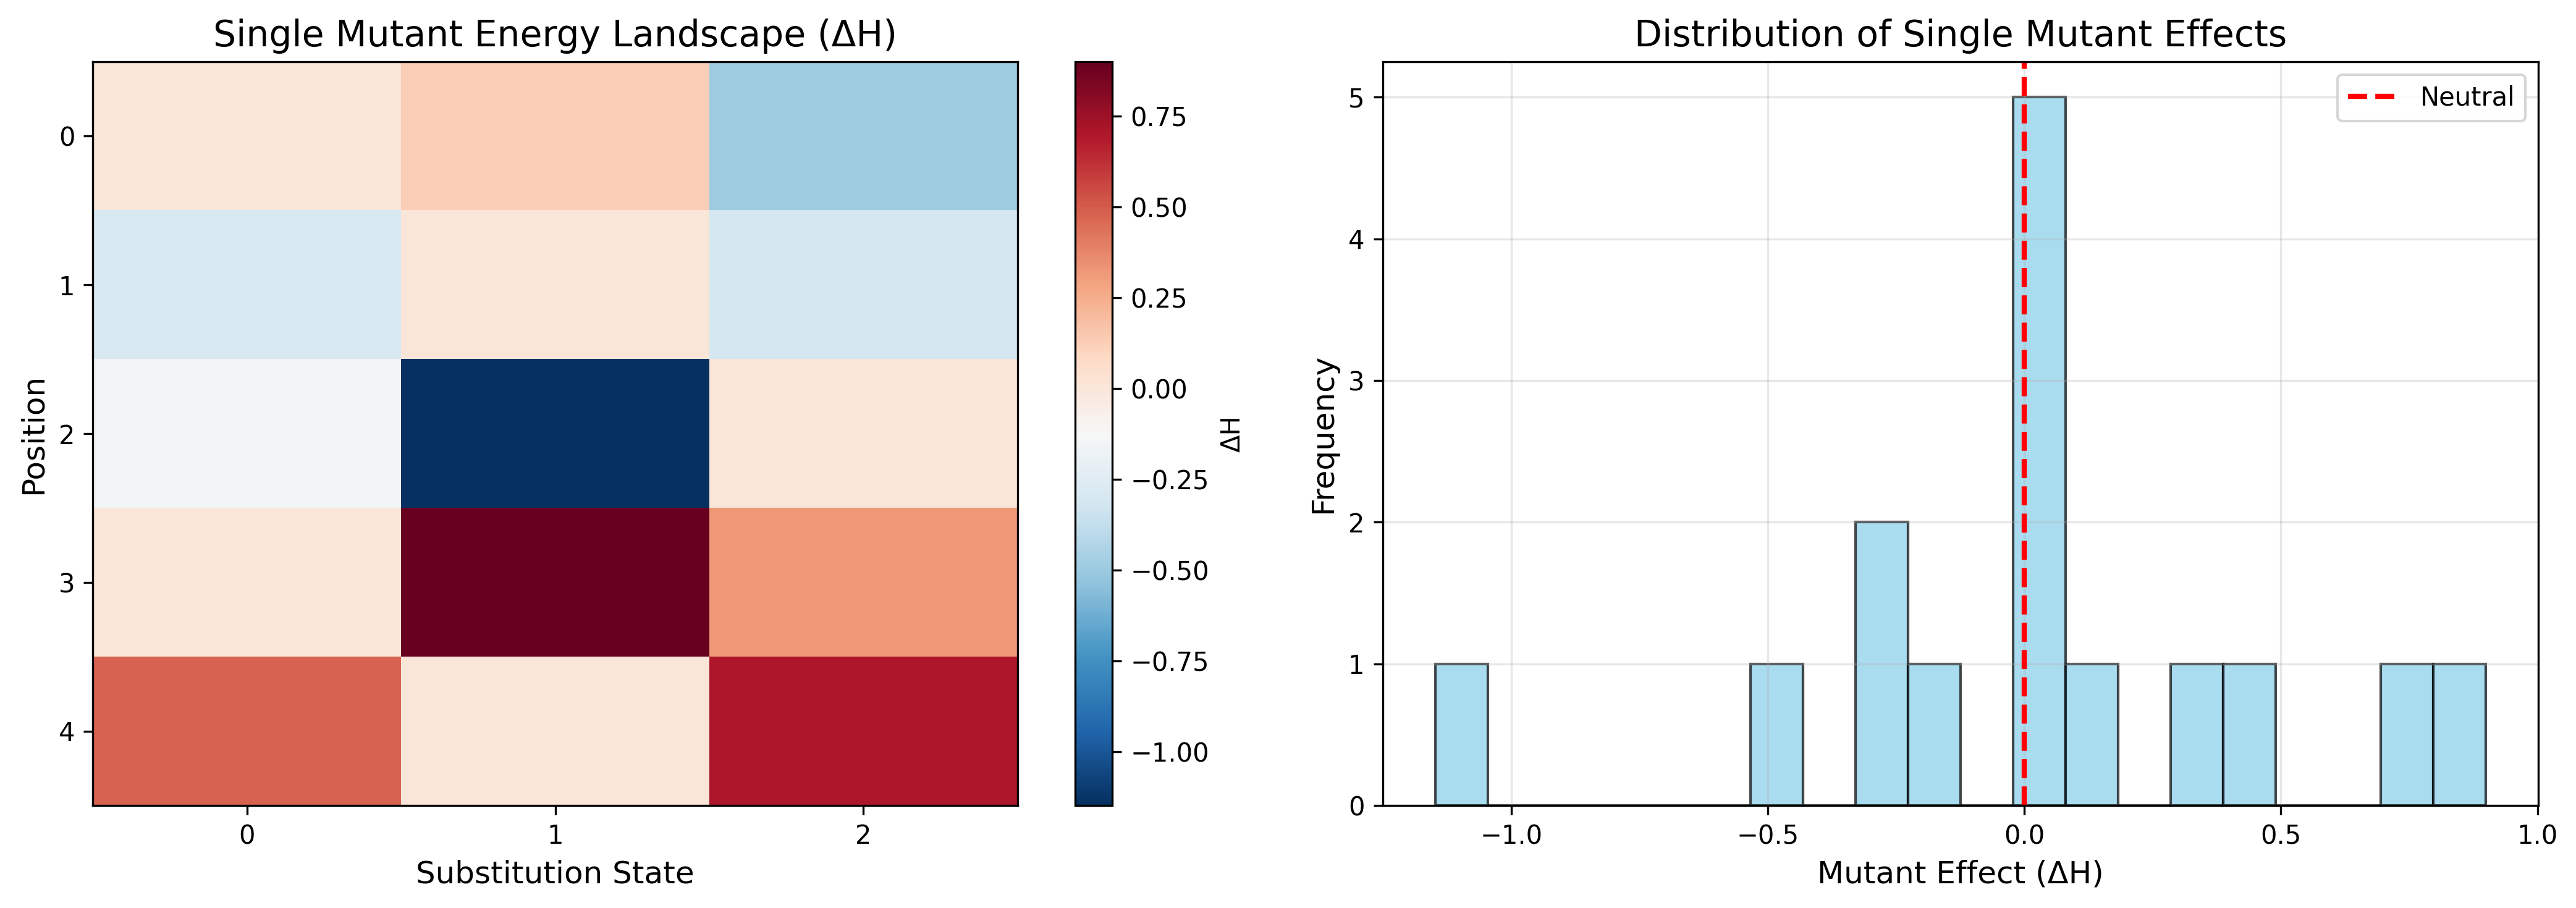


Visualization saved to notebooks/couplings_model/mutant_landscape.png


In [13]:
# Visualize single mutant landscape
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of all single mutant effects
im1 = axes[0].imshow(single_mut_H[:, :, 0], cmap='RdBu_r', aspect='auto')
axes[0].set_xlabel('Substitution State', fontsize=12)
axes[0].set_ylabel('Position', fontsize=12)
axes[0].set_title('Single Mutant Energy Landscape (ΔH)', fontsize=14)
axes[0].set_xticks(range(num_symbols))
axes[0].set_yticks(range(L))
plt.colorbar(im1, ax=axes[0], label='ΔH')

# Distribution of mutant effects
all_effects = single_mut_H[:, :, 0].flatten()
axes[1].hist(all_effects, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[1].set_xlabel('Mutant Effect (ΔH)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Single Mutant Effects', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('notebooks/couplings_model/mutant_landscape.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to notebooks/couplings_model/mutant_landscape.png")

## Summary

This notebook demonstrates the **CouplingsModel** computational core:

1. **Numba-optimized functions** for fast energy calculations
2. **Hamiltonian computation** for entire sequences
3. **Single mutant effects** across all positions
4. **Double mutant effects** with epistatic corrections
5. **Visualization** of mutational landscapes

**Real Usage**: To use CouplingsModel with actual protein data:
```python
# Load EVmutation parameters from file
model = CouplingsModel("path/to/uniref100.model_params")

# Compute mutation effects
mutations = [(10, 'A', 'V'), (20, 'L', 'F')]  # (position, from, to)
delta_E = model.delta_hamiltonian(mutations)

# Access evolutionary couplings
cn_scores = model.cn_scores  # Corrected norm scores
ecs_df = model.ecs  # Full coupling dataframe
```